### Setup

In [1]:
import sys
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import warnings
from time import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [2]:
print(sys.version)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('sklearn:',sklearn.__version__)
print('seaborn:',sns.__version__)
print('nltk:',nltk.__version__)
print('re:',re.__version__)

3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.2.3
sklearn: 0.24.1
seaborn: 0.11.1
nltk: 3.5
re: 2.2.1


In [3]:
df = pd.read_csv('./Restaurant_Reviews.tsv', delimiter = '\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


In [4]:
print('Total number of reviews = %d'%(df.shape[0]))
print('Positive reviews = %d'%(df["Liked"]==1).sum())
print('Negative reviews = %d'%(df["Liked"]==0).sum())
print("Any empty records?")
print(df.isnull().sum())

Total number of reviews = 1000
Positive reviews = 500
Negative reviews = 500
Any empty records?
Review    0
Liked     0
dtype: int64


### Exploring customer reviews

#### Stop words

Stop words are defined as the most common words in a language, e.g., the, is, a, as, such, etc. Stop word removal can be thought of as a form of feature selection. In nltk package 'not' is considered a stop word. 
In sentiment analysis, the context of the text is important which mean the negation can indicate whether a review is a positive or negative one, e.g., food was good vs. food was not good. Here, I manually exclude negation from stop word list.

In [5]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords)
negation_words = ["aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'don',"don't",'hadn',"hadn't",'hasn',"hasn't",\
'haven',"haven't",'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'no','nor','not',\
'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stopwords_v2 = [w for w in stopwords if w not in negation_words]


[nltk_data] Downloading package stopwords to /Users/isra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Lemmatisation

``In linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.`` Wikipedia

In [6]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/isra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Stemming the roots of the words

In [7]:
from nltk.stem.porter import PorterStemmer

In [8]:
def preprocess(review):
    '''Preprocess review text, get rid of special chars, convert to lower, remove stop words and apply lemmatizer.'''
    #review = review.replace("n't"," not")
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub('\s+',' ',review)
    review = review.replace("\n","")
    review = review.lower()
    review = review.split()
    review = [word for word in review if word not in stopwords_v2]
    review = [lemmatizer.lemmatize(word) for word in review]
    ps = PorterStemmer()  
    review = [ps.stem(word) for word in review] 
    
    return ' '.join(review)

In [9]:
from wordcloud import WordCloud
#https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
def plot_wordcloud(data):
    '''Show word cloud plot'''
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 43
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

### Plot word cloud for positive and negative reviews

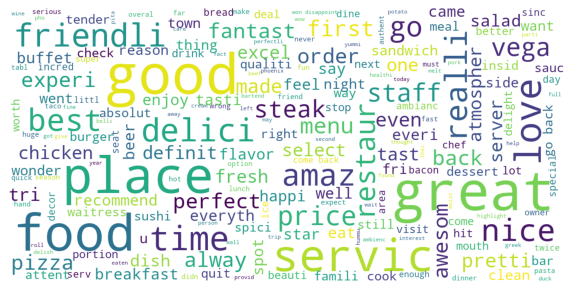

In [10]:
pos_df = df.loc[df["Liked"]==1]
pos_df['Review'] = pos_df['Review'].apply(preprocess)
pos_reviews = pos_df['Review'].values
pos_reviews = ' '.join(pos_reviews)
plot_wordcloud(pos_reviews)

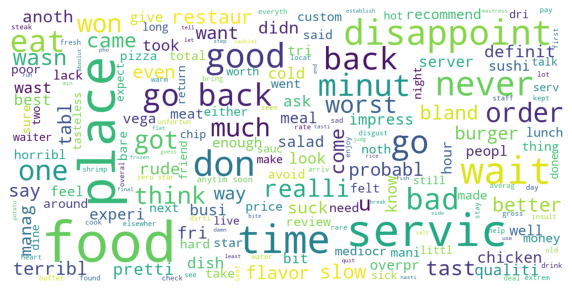

In [11]:
neg_df = df.loc[df["Liked"]==0]
neg_df['Review'] = neg_df['Review'].apply(preprocess)
neg_reviews = neg_df['Review'].values
neg_reviews = ' '.join(neg_reviews)
plot_wordcloud(neg_reviews)

### Data preparation

In [12]:
df['cleaned_review'] = df['Review'].apply(preprocess)
df[['Review','cleaned_review']].head(5)

,Review,cleaned_review
0,Wow... Loved this place.,wow love place
1,Crust is not good.,crust not good
2,Not tasty and the texture was just nasty.,not tasti textur nasti
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,stop late may bank holiday rick steve recommend love
4,The selection on the menu was great and so were the prices.,select menu great price


#### Convert a collection of text documents to a matrix of token counts

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
# Creating the Bag of Words model
vectorizer = CountVectorizer(max_features = 2000) # upper limit for featuer size, nlater will be set to the vocabulary size found in the input data.

X = vectorizer.fit_transform(df['cleaned_review'].values).toarray()
y = df["Liked"].values

#### Split train and test sets

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 43)

In [15]:
print('X_train.shape =',X_train.shape,',y_train.shape =',y_train.shape[0])
print('X_test.shape =',X_test.shape,',y_test.shape =',y_test.shape[0])

X_train.shape = (800, 1579) ,y_train.shape = 800
X_test.shape = (200, 1579) ,y_test.shape = 200


### Train Random Forest Classifier

#### Fits a classifier to the training data

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 43)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=43)

#### Predict target labels for test data

In [17]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test) # I need this for computing roc_auc_score later on

#### Evaluate predictions

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve


acc_score = accuracy_score(y_test, y_pred)*100
print('accuracy_score = %.2f%%\n'%acc_score)
print(classification_report(y_test, y_pred))
print('ROC AUC Score = %.3f'%roc_auc_score(y_test, y_proba[:,1]))

accuracy_score = 85.00%

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        97
           1       0.88      0.82      0.85       103

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200

ROC AUC Score = 0.944


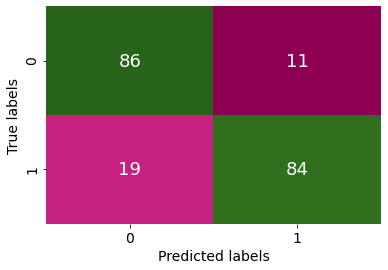

In [19]:
cm = confusion_matrix(y_test,y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax,cmap='PiYG',cbar=False,annot_kws={"fontsize":18});  #annot=True to annotate cells

ax.set_xlabel('Predicted labels',size=14)
ax.set_ylabel('True labels',size=14)
ax.xaxis.set_ticklabels(['0', '1'], size=14)
ax.yaxis.set_ticklabels(['0', '1'],size=14);

In [21]:
## I made up some data to test
test_reviews = ["Highly recommend!!", "Average service, nothing special", "good food but slow service",
               "Not a happy customer","Lukewarm food","I recommend for a quick lunch","not bad"]

for rev in test_reviews:
    rev = preprocess(rev)
    test_vec = vectorizer.transform([rev])
    print(rev,'-->',clf.predict(test_vec)[0])

highli recommend --> 1
averag servic noth special --> 0
good food slow servic --> 1
not happi custom --> 0
lukewarm food --> 0
recommend quick lunch --> 1
not bad --> 0


### Further experiment: train a bucket of models, train several different models on training data and picks the one the one that works best on test set

In [22]:
def predict_prob(clf, features, target):
    ''' Predict label probabilities and computes roc_auc score'''   
    proba_arr = clf.predict_proba(features)
    return roc_auc_score(target, proba_arr[:,1])

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Fit a classifier then predict labels and compute ROC AUC score '''
    
    # split string on upper case to print classifier name
    name = re.findall('[A-Z][^A-Z]*', clf.__class__.__name__)    
    print ("*** {} ***".format(' '.join(name)))
    
    
    start = time()
    clf.fit(X_train, y_train)
    
    print("ROC AUC score:")
    print ("\ttraining set: {:.4f}".format(predict_prob(clf, X_train, y_train)))
    print ("\ttest set: {:.4f}".format(predict_prob(clf, X_test, y_test)))
    end = time()
    print ("Total time in {:.4f} seconds\n".format(end - start))


In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier


RANDOM_STATE = 43
clf_list = [GaussianNB(),
            LogisticRegression(random_state = RANDOM_STATE),
            DecisionTreeClassifier(random_state = RANDOM_STATE),
            RandomForestClassifier(random_state = RANDOM_STATE), 
            AdaBoostClassifier(random_state = RANDOM_STATE)]

In [24]:
for clf in clf_list:
    train_predict(clf, X_train, y_train, X_test, y_test)

*** Gaussian N B ***
ROC AUC score:
	training set: 0.9268
	test set: 0.6946
Total time in 0.0696 seconds

*** Logistic Regression ***
ROC AUC score:
	training set: 0.9960
	test set: 0.9333
Total time in 0.0821 seconds

*** Decision Tree Classifier ***
ROC AUC score:
	training set: 1.0000
	test set: 0.7604
Total time in 0.1877 seconds

*** Random Forest Classifier ***
ROC AUC score:
	training set: 1.0000
	test set: 0.9429
Total time in 0.6300 seconds

*** Ada Boost Classifier ***
ROC AUC score:
	training set: 0.9051
	test set: 0.8633
Total time in 1.1371 seconds



### <font color='green'>Notes:</font> 

1. Logistic Regression and Random Forest provide the best ROC AUC score
2. Naive Bayes classifier was the fastes, however it provides the lowest ROC AUC score
3. Logistic Regression is the second fastest after NB, however the dataset is small and we need bigger datasets to assess the speed and measure the preformance of each method




